In [1]:
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
import json
import re
import collections
import numpy as np
import multiprocessing

import pandas as pd

from pyagender import PyAgender
from io import BytesIO
from PIL import Image
import requests

import cv2

Using TensorFlow backend.


In this notebook we get the age and gender based of the picture of a person.
For this we consider only a subset of all images, those containing people that have a name associated with them.

we do the following processing:

1. get ids for photos where only one person is in the image
2. get list of images associated with on person
3. use py-agender to get the age and gender

finally we do some evaluation

### 1. get ids of photos where only one person is in the image

In [5]:
df = pd.read_pickle('data/named_subjects.pkl')

In [6]:
df.head()

,id,dc:title,title,subjects,names
7,https://gallica.bnf.fr/ark:/12148/btv1b53168872x,"[Me Auguez] : [photographie, tirage de démonst...",Me Auguez,"[Auguez, Mathilde (1868-1955) -- Portraits]","[Auguez, Mathilde (1868-1955)]"
8,https://gallica.bnf.fr/ark:/12148/btv1b531688701,"[Me Auguez] : [photographie, tirage de démonst...",Me Auguez,"[Auguez, Mathilde (1868-1955) -- Portraits]","[Auguez, Mathilde (1868-1955)]"
9,https://gallica.bnf.fr/ark:/12148/btv1b53171770j,"M. Bruant : [photographie, tirage de démonstra...",M Bruant,"[Bruant, Aristide (1851-1925) -- Portraits]","[Bruant, Aristide (1851-1925)]"
10,https://gallica.bnf.fr/ark:/12148/btv1b53168873c,"Me Auguez : [photographie, tirage de démonstra...",Me Auguez,"[Auguez, Mathilde (1868-1955) -- Portraits]","[Auguez, Mathilde (1868-1955)]"
13,https://gallica.bnf.fr/ark:/12148/btv1b531651494,"M. A. Brasseur : [photographie, tirage de démo...",M A Brasseur,"[Brasseur, Albert (1862-1932) -- Portraits]","[Brasseur, Albert (1862-1932)]"


In [7]:
person_per_image = df.names.map(len)

In [8]:
person_per_image.value_counts()

1    12425
2      711
3      105
4        9
5        3
6        1
Name: names, dtype: int64

In [9]:
individual_portraits = person_per_image == 1

How many pictures do we have of one person?

In [10]:
individual_portraits_df = df[individual_portraits].copy()
individual_portraits_df['name'] = individual_portraits_df.names.map(lambda x: x[0])

In [11]:
individual_portraits_df.groupby('name').id.count().sort_values()

name
Moigno, François (1804-1884)                         1
Huet, Paul (1803-1869)                               1
Huerta, Trinidad (1800-1874)                         1
Stewart, Julius Leblanc (1855-1919)                  1
Clapisson, Antoine-Louis (1808-1866)                 1
                                                  ... 
Mily-Meyer, Emilie (1862-1927)                     101
Gélabert, Conchita, Marie (1858-19.. ; actrice)    102
Théo, Louise (1854-1922)                           146
Réjane (1856-1920)                                 147
Bernhardt, Sarah (1844-1923)                       356
Name: id, Length: 1894, dtype: int64

49 people don't have portraits. That's okay, we focus on the people that do.

In [12]:
unmatched_people = set([i for x in df.names.to_list() for i in x])\
    .difference(set(individual_portraits_df['name'].tolist()))

In [13]:
len(unmatched_people)

49

### 2. get list associated to person

In [14]:
personal_portrait_image = individual_portraits_df.groupby('name').apply(lambda x: x.id.tolist())
personal_portrait_image = personal_portrait_image.rename('id').reset_index()

In [15]:
personal_portrait_image

,name,id
0,"Abbatucci, Séverin (1821-1888)",[https://gallica.bnf.fr/ark:/12148/btv1b530716...
1,"Abbott, Emma (1850-1891)",[https://gallica.bnf.fr/ark:/12148/btv1b531637...
2,"Abbéma, Louise (1858-1927)",[https://gallica.bnf.fr/ark:/12148/btv1b530715...
3,"Abney, William de Wiveleslie (1843-1920)",[https://gallica.bnf.fr/ark:/12148/btv1b531651...
4,"Abott, Bessie (1878-1919)",[https://gallica.bnf.fr/ark:/12148/btv1b531175...
...,...,...
1889,"Énault, Louis (1824-1900)",[https://gallica.bnf.fr/ark:/12148/btv1b530653...
1890,"Éon, Charles de Beaumont d' (1728-1810)",[https://gallica.bnf.fr/ark:/12148/btv1b530664...
1891,"Étex, Antoine (1808-1888)",[https://gallica.bnf.fr/ark:/12148/btv1b531271...
1892,"Étiévant, Henri (1870-1953)",[https://gallica.bnf.fr/ark:/12148/btv1b531119...


In [16]:
agender = PyAgender() 

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


### 3. get age-gender lables 

the api not only gives us an age and gender estimate, but also the rectangle pointing to the face. We keep that as it can be used for the face map 

In [17]:
def get_image(doc):
    url = doc+'/f1.highres.jpg'
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = np.array(img)
    return img

def get_age_gender_estimates(image_docs):
    i = 0
    estimates = []
    
    #handle case where for one image of personn we can't get estimates
    while i < len(image_docs) and len(estimates) == 0:
        img = get_image(image_docs[i])
        retries = 0
        while retries < 5 and len(estimates) == 0:
            estimates = agender.detect_genders_ages(img)
            retries += 1
        i = i+1
        
    if estimates:
        # use first estimate as it is most likely one
        result = estimates[0]
        result['number'] = len(estimates)
        result['id'] = image_docs[i-1]
        return result
    
    return {}

In [18]:
if False:
    age_gender_lables = personal_portrait_image.id.map(get_age_gender_estimates)  
    age_gender_lables = pd.DataFrame(age_gender_lables.tolist())
    age_gender_lables['name'] = personal_portrait_image.name
    age_gender_lables.to_json('data/age_gender_labeles.json')

In [19]:
age_gender_lables = pd.read_json('data/age_gender_labeles.json')

In [20]:
true_gender = pd.read_pickle('data/bnf_table_full.pkl')

In [21]:
len(true_gender) - len(age_gender_lables)

-20

In [22]:
true_gender = true_gender[['name', 'gender']]

In [23]:
age_gender_lables = pd.merge(true_gender, age_gender_lables, on='name', suffixes=('_true', '_estimated'),how='left')

In [24]:
age_gender_lables.gender_true.value_counts()

masculin    1507
féminin      359
Name: gender_true, dtype: int64

In [25]:
age_gender_lables['gender_estimates_binary'] =\
    age_gender_lables.loc[age_gender_lables.gender_estimated.notna(), 'gender_estimated'].map(lambda x: 'féminin' if x>.5 else 'masculin')

In [26]:
age_gender_lables.gender_estimates_binary.isna().value_counts()

False    1752
True      122
Name: gender_estimates_binary, dtype: int64

In [27]:
age_gender_lables.gender_estimates_binary.value_counts()

masculin    1630
féminin      122
Name: gender_estimates_binary, dtype: int64

In [28]:
age_gender_lables.to_json('data/age_gender_labeles_augmented.json')

# evaluation of method


evaluation of algorithm itself is presented on wikipage of py-agender: https://github.com/yu4u/age-gender-estimation

In [29]:
len(age_gender_lables[age_gender_lables.age.isna()])

122

can't get lables for 46 people

In [30]:
unfound = age_gender_lables[age_gender_lables.age.isna()].name.tolist()

In [31]:
personal_portrait_image[personal_portrait_image.name.isin(unfound)].id.map(lambda x:x[0])

42      https://gallica.bnf.fr/ark:/12148/btv1b53092428m
54      https://gallica.bnf.fr/ark:/12148/btv1b531189234
122     https://gallica.bnf.fr/ark:/12148/btv1b53146883g
195     https://gallica.bnf.fr/ark:/12148/btv1b531007953
196     https://gallica.bnf.fr/ark:/12148/btv1b53100866p
                              ...                       
1714    https://gallica.bnf.fr/ark:/12148/btv1b53118782d
1753    https://gallica.bnf.fr/ark:/12148/btv1b531044920
1773    https://gallica.bnf.fr/ark:/12148/btv1b53066502x
1806    https://gallica.bnf.fr/ark:/12148/btv1b53117422f
1812    https://gallica.bnf.fr/ark:/12148/btv1b53120301p
Name: id, Length: 76, dtype: object

number of faces that we got:

In [32]:
age_gender_lables.number.value_counts()

1.0    1604
2.0     136
3.0       8
4.0       4
Name: number, dtype: int64

Text(0.5, 0, 'age in years')

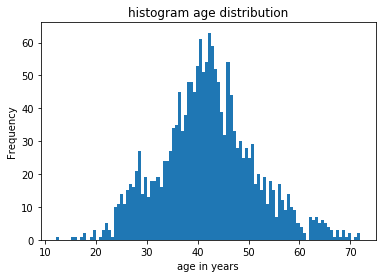

In [33]:
age_gender_lables.age.plot(kind='hist', bins=100)
plt.title('histogram age distribution')
plt.xlabel('age in years')

mostly men

In [34]:
age_gender_lables[age_gender_lables.gender_estimated.notna()]

,name,gender_true,left,top,right,bottom,width,height,gender_estimated,age,number,id,gender_estimates_binary
0,"Abbatucci, Séverin (1821-1888)",masculin,269.0,268.0,748.0,747.0,479.0,479.0,0.116277,47.741472,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53071608k,masculin
1,"Abbott, Emma (1850-1891)",féminin,433.0,316.0,580.0,463.0,147.0,147.0,0.585720,27.465579,2.0,https://gallica.bnf.fr/ark:/12148/btv1b531622212,féminin
2,"Abbéma, Louise (1858-1927)",féminin,250.0,718.0,403.0,871.0,153.0,153.0,0.377803,40.358822,3.0,https://gallica.bnf.fr/ark:/12148/btv1b53071525p,masculin
3,"Abney, William de Wiveleslie (1843-1920)",masculin,155.0,134.0,872.0,851.0,717.0,717.0,0.104841,44.487285,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53165139q,masculin
4,"Abott, Bessie (1878-1919)",féminin,415.0,184.0,615.0,384.0,200.0,200.0,0.389818,27.194442,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53117510h,masculin
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,"Énault, Louis (1824-1900)",masculin,355.0,310.0,596.0,551.0,241.0,241.0,0.033713,45.716630,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53065399p,masculin
1870,"Éon, Charles de Beaumont d' (1728-1810)",masculin,288.0,437.0,583.0,732.0,295.0,295.0,0.358721,26.078685,1.0,https://gallica.bnf.fr/ark:/12148/btv1b530664193,masculin
1871,"Étex, Antoine (1808-1888)",masculin,310.0,214.0,739.0,643.0,429.0,429.0,0.108013,47.732863,1.0,https://gallica.bnf.fr/ark:/12148/btv1b531271467,masculin
1872,"Étiévant, Henri (1870-1953)",masculin,448.0,284.0,601.0,437.0,153.0,153.0,0.081239,31.406526,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53111936g,masculin


/Users/lguillain/opt/anaconda3/envs/fdh/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  after removing the cwd from sys.path.
/Users/lguillain/opt/anaconda3/envs/fdh/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  


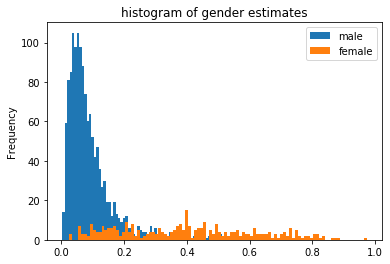

In [35]:
plt.title('histogram of gender estimates')
plt.ylabel('count')
age_gender_lables[(age_gender_lables.gender_true =='masculin') &\
                               age_gender_lables.gender_estimated.notna()].gender_estimated.plot('hist', bins=100)
age_gender_lables[(age_gender_lables.gender_true !='masculin') &\
                               age_gender_lables.gender_estimated.notna()].gender_estimated.plot('hist', bins=100)
plt.legend(['male', 'female'])

Clearly, given the name something went wrong

In [36]:
CM = confusion_matrix(age_gender_lables.gender_true == 'masculin',
                 age_gender_lables.gender_estimates_binary == 'masculin')

In [37]:
CM

array([[ 130,  237],
       [ 114, 1393]])

In [38]:
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

In [39]:
FN

114

In [40]:

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [41]:
ACC

0.812700106723586

## Example of multiple matches or mismatches

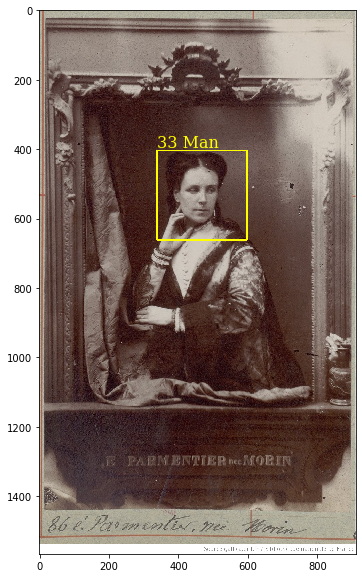

In [44]:
font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'normal',
        'size': 16,
        }
img = get_image(age_gender_lables.id[1296])

for detect in [age_gender_lables.iloc[1296]]:
    gender =  'Woman' if detect['gender_estimated'] > .5 else 'Man'
    plt.figure(figsize=(10, 10))
    plt.text(detect['left'], detect['top']-10, str(detect['age'])[:2] + ' ' + gender, fontdict=font)
plt.imshow(cv2.rectangle(img, (int(detect['left']), int(detect['top'])), (int(detect['right']), int(detect['bottom'])), (255, 255, 0), 3))